In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline
import json
import seaborn
import re
import seaborn as sns

## Load the data using pandas

In [22]:
df = pd.read_csv('data.csv', parse_dates=True, dtype = {'Id':'string', 'Title': 'string', 'Company': 'string', 'Date': 'string', 'Location': 'string', 'Area': 'string', 'Classification': 'string', 'SubClassification': 'string', 'Requirement': 'string', 'FullDescription': 'string', 'LowestSalary': 'int', 'HighestSalary': 'int', 'JobType': 'string'})

## Clean the data

In [23]:
df['Id'] = df['Id'].str.extract('(^[0-9]+)').astype(int)                         
df['Date'] = pd.to_datetime(df['Date'])

In [24]:
print('\n', df.dtypes)


 Id                                 int32
Title                             string
Company                           string
Date                 datetime64[ns, UTC]
Location                          string
Area                              string
Classification                    string
SubClassification                 string
Requirement                       string
FullDescription                   string
LowestSalary                       int32
HighestSalary                      int32
JobType                           string
dtype: object


## Hypothesis 1: Tech will be dominant in capital cities

In [25]:
class SubSector:
    def __init__(self, name):
        self.salaries = list()
        self.name = name
    def __str__(self):
        return self.name 
    def AddSalary(self, lowest, highest):
        self.salaries.append((lowest, highest))
    def NumSalaries(self):
        return len(self.salaries)
    def AvgSalary(self):
        total = 0
        for tup in self.salaries:
            total += tup[1]
        return total / self.NumSalaries()
    def AllSalaries(self):
        allSalaries = list()
        for salary in self.salaries:
            allSalaries.append((self.name, salary[1]))
        return allSalaries

class Sector:
    def __init__(self, name):
        self.subSectors = dict()
        self.name = name
    def __str__(self):
        return self.name 
    def AddSubSector(self, subSector, lowestSalary, highestSalary):
        if subSector not in self.subSectors:
            self.subSectors.update({subSector : SubSector(subSector)})
        self.subSectors[subSector].AddSalary(lowestSalary, highestSalary)
    def MostDominantSubSector(self):
        subSector = object()
        amt = 0
        for key in self.subSectors:
            cur = self.subSectors[key]
            curAmt = cur.NumSalaries()
            if cur > amt:
                amt = cur
                subSector = cur
        return subSector
    def NumSubSectors(self):
        return len(self.subSectors)
    def AvgSalary(self):
        total = 0
        for key in self.subSectors:
            subSector = self.subSectors[key]
            total += subSector.AvgSalary()
        return total / self.NumSubSectors()
    def AllSalaries(self):
        allSalaries = list()
        for key in self.subSectors:
            subSector = self.subSectors[key]
            subSalaries = subSector.AllSalaries()
            for subSalary in subSalaries:
                allSalaries.append((self.name, subSalary[0], subSalary[1]))
        return allSalaries

class City:
    def __init__(self, name):
        self.sectors = dict()
        self.sectorCounts = dict()
        self.name = name
        self.capital = name in ["Canberra", "Sydney", "Darwin", "Brisbane", "Adelaide", "Hobart", "Melbourne", "Perth", "ACT"]
    def IsCapital(self):
        return self.capital
    def __str__(self):
        return self.name 
    def AddSector(self, sector, subSector, lowestSalary, highestSalary):
        if sector not in self.sectors:
            self.sectorCounts.update({sector : 1})
            self.sectors.update({sector: Sector(sector)})
        else:
            self.sectorCounts[sector] += 1
        self.sectors[sector].AddSubSector(subSector, lowestSalary, highestSalary)
    def MostDominantSector(self):
        sector = object()
        amt = 0
        for key in self.sectorCounts:
            cur = self.sectorCounts[key]
            if cur > amt:
                amt = cur
                sector = self.sectors[key]
        return sector
    def NumSectors(self):
        return len(self.sectors)
    def AvgSalary(self):
        total = 0
        for key in self.sectors:
            total += self.sectors[key].AvgSalary()
        return total / self.NumSectors()
    def AllSalaries(self):
        allSalaries = list()
        for key in self.sectors:
            sector = self.sectors[key]
            salaries = sector.AllSalaries()
            for salary in salaries:
                allSalaries.append((self.name, salary[0], salary[1], salary[2]))
        return allSalaries

cityDict = dict()
for index, row in df.iterrows():
    city = row["Location"]
    sector = row["Classification"]
    subSector = row["SubClassification"]
    lowestSalary = row["LowestSalary"]
    highestSalary = row["HighestSalary"]
    
    if not pd.isnull(city) and not pd.isnull(sector) and not pd.isnull(subSector) and not pd.isnull(lowestSalary) and not pd.isnull(highestSalary): 
        if city not in cityDict:
            cityDict.update({city : City(city)})
        cityDict[city].AddSector(sector, subSector, lowestSalary, highestSalary)

allCities = list()
capitals = list()
nonCapitals = list()
for key in cityDict:
    cur = cityDict[key]
    if cityDict[key].IsCapital():
        capitals.append(cur)
    else:
        nonCapitals.append(cur)

#print("Capitals")
for capital in capitals:
    dominant = capital.MostDominantSector()
    #print(str(capital) + " (" + str(dominant) + ") - " + str(dominant.AvgSalary()))
    allCities.append([str(capital), str(dominant), dominant.AvgSalary()])
    
#print("\nNonCapitals")
for nonCapital in nonCapitals:
    dominant = nonCapital.MostDominantSector()
    #print(str(nonCapital) + " (" + str(dominant) + ") - " + str(dominant.AvgSalary()))
    allCities.append([str(nonCapital), str(dominant), dominant.AvgSalary()])

#print(allCities)
with open('baseData.json', 'w') as outfile:
    json.dump(allCities, outfile)

### Text analysis

In [26]:
requirements = list()
for index, row in df.iterrows():
    sector = str(row["Classification"])
    requirement = str(row["Requirement"]).strip()
    
    if sector == "Information & Communication Technology":
        requirements.append(requirement)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words = 'english', max_features=500)

features = tfidf.fit(requirements)
corpus_tf_idf = tfidf.transform(requirements)

sum_words = corpus_tf_idf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]

print(sorted(words_freq, key = lambda x: x[1], reverse=True)[:5])

query = "vmware java"

new_features = tfidf.transform([query])

cosine_similarities = linear_kernel(new_features, corpus_tf_idf).flatten()
related_docs_indices = cosine_similarities.argsort()[::-1]

topk = 5
print('Top-{0} documents'.format(topk))
for i in range(topk):
    print(i, ": ", requirements[related_docs_indices[i]])

[('contract', 849.9973961419004), ('opportunity', 832.9341336343739), ('join', 829.6022350961781), ('team', 793.2975806517229), ('business', 720.8327124871363)]
Top-5 documents
0 :  VMware Engineer needed for a VmWare Migration project. We have a project required to migrate an ESXi Server remotely.
1 :  Maintain, Support and provide Virtualisation (VMware) solutions to our enterprise clients | CBD Location | VMware/ vRealise/ Vblock
2 :  This is a great role for a Java Developer with VMWare and AWS to work for a large CBD based Financial organisation
3 :  Architect Virtualisation VMWare Cloud TOGAF Permanent
4 :  Architect Virtualisation VMWare Cloud TOGAF Permanent


### Make a model to predict wage trends (forecasting)

### Methods:
##### 1) Moving Average
##### 2) Weighted Moving Average
##### 3) Exponential Smoothing
##### 4) Exponential Smoothing with Trend
##### 5) Seasonality

In [28]:
salary_df = df[["Date", "HighestSalary"]]
salary_df = salary_df.rename(columns = {'HighestSalary': 'Salary'} )

In [29]:
def GetStartOfWeek(date):
    return date - pd.to_timedelta(date.dt.weekday, unit='D')

def GetStartOfMonth(date):
    return date.to_numpy().astype('datetime64[M]')

def AddMonths(date, numMonths):
    return date + pd.DateOffset(months=numMonths)

def AddWeeks(date, numWeeks):
    numDays = 7 * numWeeks
    return date + pd.DateOffset(days=numDays)

salary_df.sort_values(by=["Date"], inplace=True, ascending=True)

startTime = salary_df.iloc[0]["Date"]
salary_df['Period'] = salary_df["Date"].dt.isocalendar().week + ((salary_df["Date"].dt.isocalendar().year - startTime.year) * 52)
#salary_df['Period'] = salary_df['Date'].dt.month + ((salary_df['Date'].dt.isocalendar().year - startTime.year) * 12)

#timeA = salary_df.iloc[224458]['Date']
#timeB = salary_df.iloc[224459]['Date']
#print(timeA, " ", timeB)
#print(timeA.month, " ", timeB.month)

In [30]:
period_df = pd.DataFrame(columns=['Period', 'TotalSalary', 'NumSalaries'])
periods = list()
salaries = list()
amounts = list()

curPeriod = 0
curTotal = 0
curAmt = 0
for index, row in salary_df.iterrows():
    period = row['Period']
    salary = row['Salary']
    
    if period not in periods:
        periods.append(period)
        curPeriod = period
        if curTotal > 0:
            salaries.append(curTotal)
            amounts.append(curAmt)
            curTotal = 0
            curAmt = 0
            
    curTotal += salary
    curAmt += 1
    
salaries.append(curTotal)
amounts.append(curAmt)
        
period_df["Period"] = periods
period_df["TotalSalary"] = salaries
period_df["NumSalaries"] = amounts
period_df["AvgSalary"] = period_df["TotalSalary"] / period_df["NumSalaries"]

    Period  TotalSalary  NumSalaries   AvgSalary  MovingAverage  ExpSmoothing
0       40      2656176        23673  112.202763            NaN    112.202763
1       41      2697453        22641  119.140188            NaN    112.202763
2       42      3856715        40213   95.907169            NaN    117.752703
3       43      1704822         5779  295.002942     109.083373    100.276276
4       44      3145816        26801  117.376814     170.016766    256.057609
5       45      2030026        24041   84.440165     169.428975    145.112973
6       46       378918        10028   37.785999     165.606640     96.574726
7       47        47763          359  133.044568      79.867659     49.543745
8       48       738908         1397  528.924839      85.090244    116.344404
9       49      1839500         4048  454.421937     233.251802    446.408752
10      50      4700886        38522  122.031203     372.130448    452.819300
11      51      2365883        17079  138.525850     368.459326 

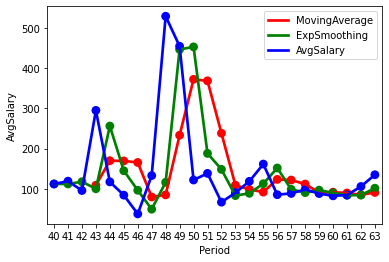

In [33]:
def MovingAverage(df, column, newColumn, k):
    values = list()
    num_df = len(df)
    for m in range(0, num_df):
        if m < k:
            sale_predict = float('nan')
        else:
            history = df[column][m-k:m]
            sale_predict = history.mean()
        values.append(sale_predict)
    
    df[newColumn] = values
    return df

def ExponentialSmoothing(df, column, newColumn, alpha):
    values = [df[column][0]]
    num_df = len(df)
    for m in range(0, num_df):
        predict = (alpha * df[column][m]) + ((1-alpha) * values[m])
        values.append(predict)
    
    df[newColumn] = values[0:len(values)-1] # HELP: do i use this?
    #df[newColumn] = values[1:]             # or this?
    
    return df

period_df = MovingAverage(period_df, 'AvgSalary', 'MovingAverage', 3)
period_df = ExponentialSmoothing(period_df, 'AvgSalary', 'ExpSmoothing', 0.8)
print(period_df)

f, ax = plt.subplots(1, 1)
sns.pointplot(x='Period', y='MovingAverage', data=period_df, color='r')
sns.pointplot(x='Period', y='ExpSmoothing', data=period_df, color='g')
sns.pointplot(x='Period', y='AvgSalary', data=period_df, color='b')
ax.legend(handles=ax.lines[::len(period_df)+1], labels=["MovingAverage", "ExpSmoothing", "AvgSalary"])
plt.show()

#compression_opts = dict(method='zip', archive_name='export.csv')  
#salary_period_df.to_csv('export.zip', index=False, compression=compression_opts) 

### The average of the top 25% of salaries in the tech industry will be larger than the average of the top 25% of salaries in any other sector.

In [12]:
allSalaries = list()
for key in cityDict:
    city = cityDict[key]
    allSalaries.extend(city.AllSalaries())
    
techSalaries = list()
otherSalaries = list()
for salary in allSalaries:
    sector = salary[1]
    if sector == "Information & Communication Technology":
        techSalaries.append(salary)
    else:
        otherSalaries.append(salary)